In [74]:
# Imports
%reload_ext autoreload
%autoreload 2 
import os
from embed_time.splitter_static import DatasetSplitter
from embed_time.dataset_static import ZarrCellDataset, ZarrCellDataset_specific
from embed_time.dataloader_static import collate_wrapper
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [75]:
# Helper functions
def plot_cell_data(dataset_image):
    """
    Plot all data for a selected image across all channels from a ZarrCellDataset.
    
    Args:
    dataset (ZarrCellDataset): The dataset containing the images
    image_index (int): Index of the image to plot (default: 0)
    """
    
    sample = dataset_image
    original_images = sample['original_image']
    cell_masks = sample['cell_mask']
    nuclei_masks = sample['nuclei_mask']
    cell_images = sample['cell_image']
    nuclei_images = sample['nuclei_image']
    
    # If cell and nuclei masks are 2 dimensional, add a channel dimension
    if cell_masks.ndim == 2:
        cell_masks = cell_masks[None]
    if nuclei_masks.ndim == 2:
        nuclei_masks = nuclei_masks[None]

    num_channels = original_images.shape[0]
    
    # Create a figure with 5 rows (original, cell mask, nuclei mask, cell image, nuclei image)
    # and num_channels columns
    fig, axes = plt.subplots(5, num_channels, figsize=(4*num_channels, 20))
    
    # If there's only one channel, we need to reshape axes to be 2D
    if num_channels == 1:
        axes = axes.reshape(-1, 1)
    
    titles = ['Original', 'Cell Mask', 'Nuclei Mask', 'Cell Image', 'Nuclei Image']
    
    for channel in range(num_channels):
        # Original image
        axes[0, channel].imshow(original_images[channel], cmap='gray')
        axes[0, channel].set_title(f'{titles[0]} - Channel {channel}')
        
        # Cell mask (same for all channels)
        axes[1, channel].imshow(cell_masks[0], cmap='gray')
        axes[1, channel].set_title(f'{titles[1]} - Channel {channel}')
        
        # Nuclei mask (same for all channels)
        axes[2, channel].imshow(nuclei_masks[0], cmap='gray')
        axes[2, channel].set_title(f'{titles[2]} - Channel {channel}')
        
        # Cell image
        axes[3, channel].imshow(cell_images[channel], cmap='gray')
        axes[3, channel].set_title(f'{titles[3]} - Channel {channel}')
        
        # Nuclei image
        axes[4, channel].imshow(nuclei_images[channel], cmap='gray')
        axes[4, channel].set_title(f'{titles[4]} - Channel {channel}')
    
    # Remove axis ticks
    for ax in axes.flatten():
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

def print_cell_data_shapes(dataset_image):
    """
    Print the shapes of all data for a selected image across all channels from a ZarrCellDataset.
    
    Args:
    dataset (ZarrCellDataset): The dataset containing the images
    image_index (int): Index of the image to examine (default: 0)
    """
    
    sample = dataset_image
    
    print(f"Original Image: {sample['original_image'].shape}")
    print(f"Cell Mask: {sample['cell_mask'].shape}")
    print(f"Nuclei Mask: {sample['nuclei_mask'].shape}")
    print(f"Cell Image: {sample['cell_image'].shape}")
    print(f"Nuclei Image: {sample['nuclei_image'].shape}")

In [76]:
# Usage example:
parent_dir = '/mnt/efs/dlmbl/S-md/'
output_file = '/home/S-md/embed_time/notebooks/splits/example_split.csv'
train_ratio = 0.7
val_ratio = 0.15
num_workers = -1

# Create the dataset split CSV file
DatasetSplitter(parent_dir, output_file, train_ratio, val_ratio, num_workers).generate_split()

Processing 2 genes...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Combining results...
Creating DataFrame and saving CSV...
Dataset split CSV saved to /home/S-md/embed_time/notebooks/splits/example_split.csv


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.3s finished


The dataset contains 671 images.
Original Image: (4, 256, 256)
Cell Mask: (1, 256, 256)
Nuclei Mask: (1, 256, 256)
Cell Image: (4, 150, 150)
Nuclei Image: (4, 150, 150)


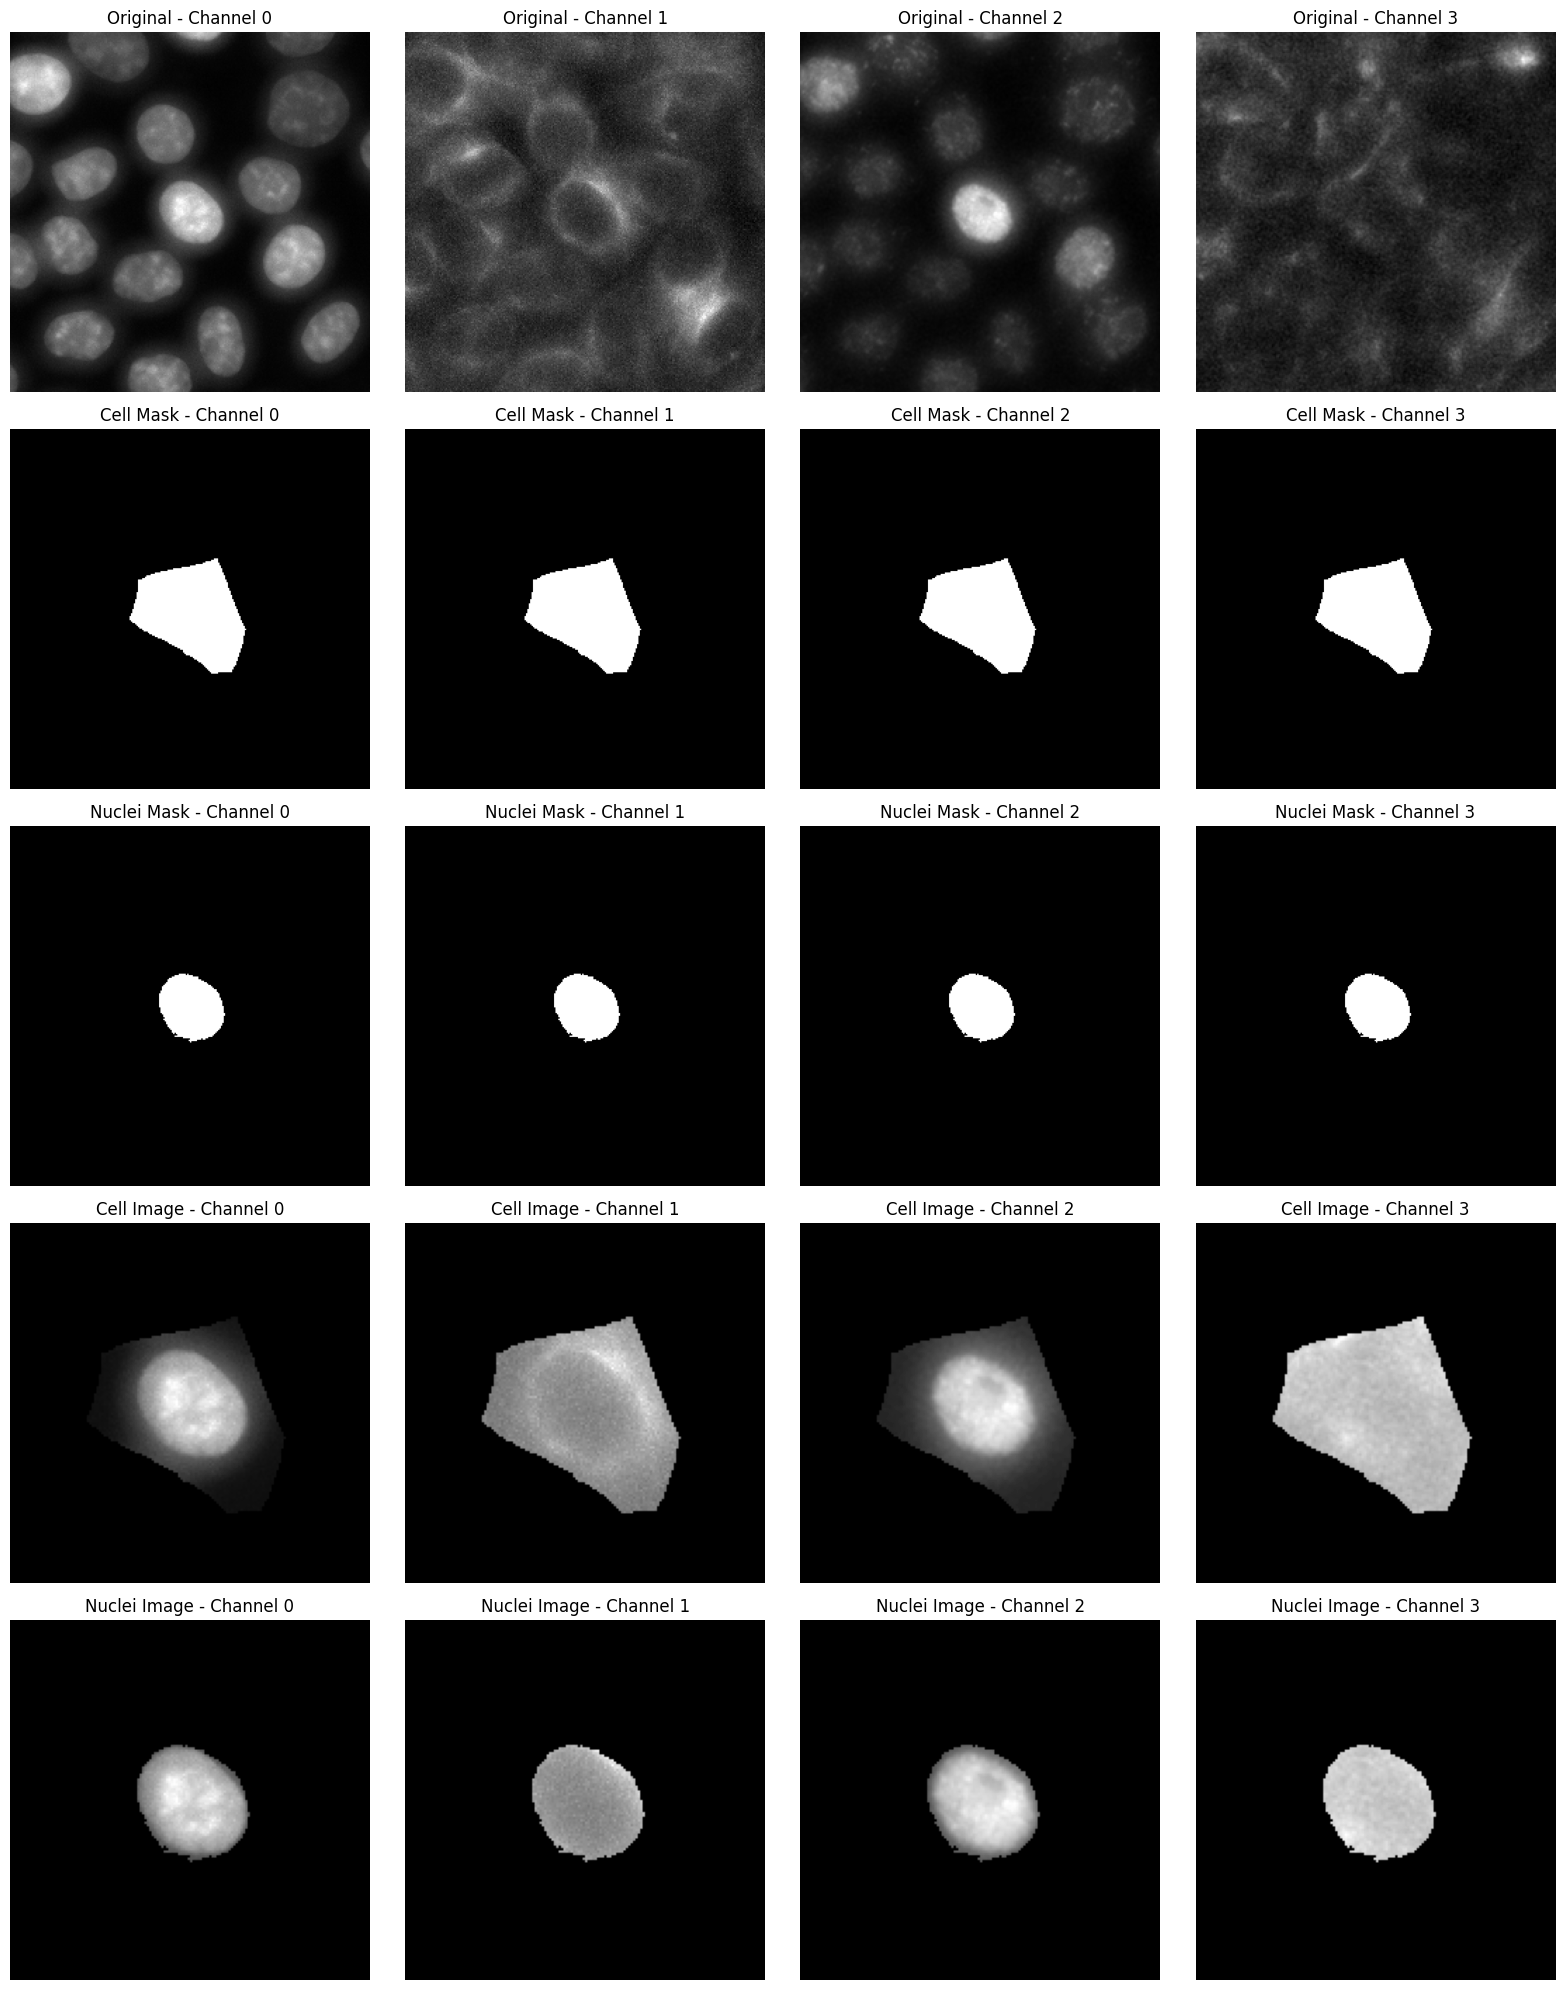

In [77]:
# Usage example:
parent_dir = '/mnt/efs/dlmbl/S-md/'
gene_name = 'AAAS'
barcode_name = 'ATATGAGCACAATAACGAGC'
channels = [0, 1, 2, 3]
cell_cycle_stages = 'interphase'
transform = "masks"
crop_size = 150

# Create the dataset
dataset = ZarrCellDataset_specific(parent_dir, gene_name, barcode_name, channels, cell_cycle_stages, transform, crop_size)

# Print the number of images and shapes of the data
print(f"The dataset contains {len(dataset)} images.")

# Print the shapes of the data for the first image
print_cell_data_shapes(dataset.__getitem__(42))

# Plot the first image (index 0)
plot_cell_data(dataset.__getitem__(42))

In [78]:
# Create a DataLoader for the dataset
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Iterate over the DataLoader

for i, batch in enumerate(dataloader):
    print(f"Batch {i}:")
    print(batch.keys())
    print(f"Original Image: {batch['original_image'].shape}")
    print(f"Cell Mask: {batch['cell_mask'].shape}")
    print(f"Nuclei Mask: {batch['nuclei_mask'].shape}")
    print(f"Cell Image: {batch['cell_image'].shape}")
    print(f"Nuclei Image: {batch['nuclei_image'].shape}")
      
    # Only plot the first batch
    break

Batch 0:
dict_keys(['gene', 'barcode', 'stage', 'original_image', 'cell_mask', 'nuclei_mask', 'cell_image', 'nuclei_image'])
Original Image: torch.Size([2, 4, 256, 256])
Cell Mask: torch.Size([2, 1, 256, 256])
Nuclei Mask: torch.Size([2, 1, 256, 256])
Cell Image: torch.Size([2, 4, 150, 150])
Nuclei Image: torch.Size([2, 4, 150, 150])


The dataset contains 13605 images.
Original Image: (4, 256, 256)
Cell Mask: (256, 256)
Nuclei Mask: (256, 256)
Cell Image: (4, 150, 150)
Nuclei Image: (4, 150, 150)


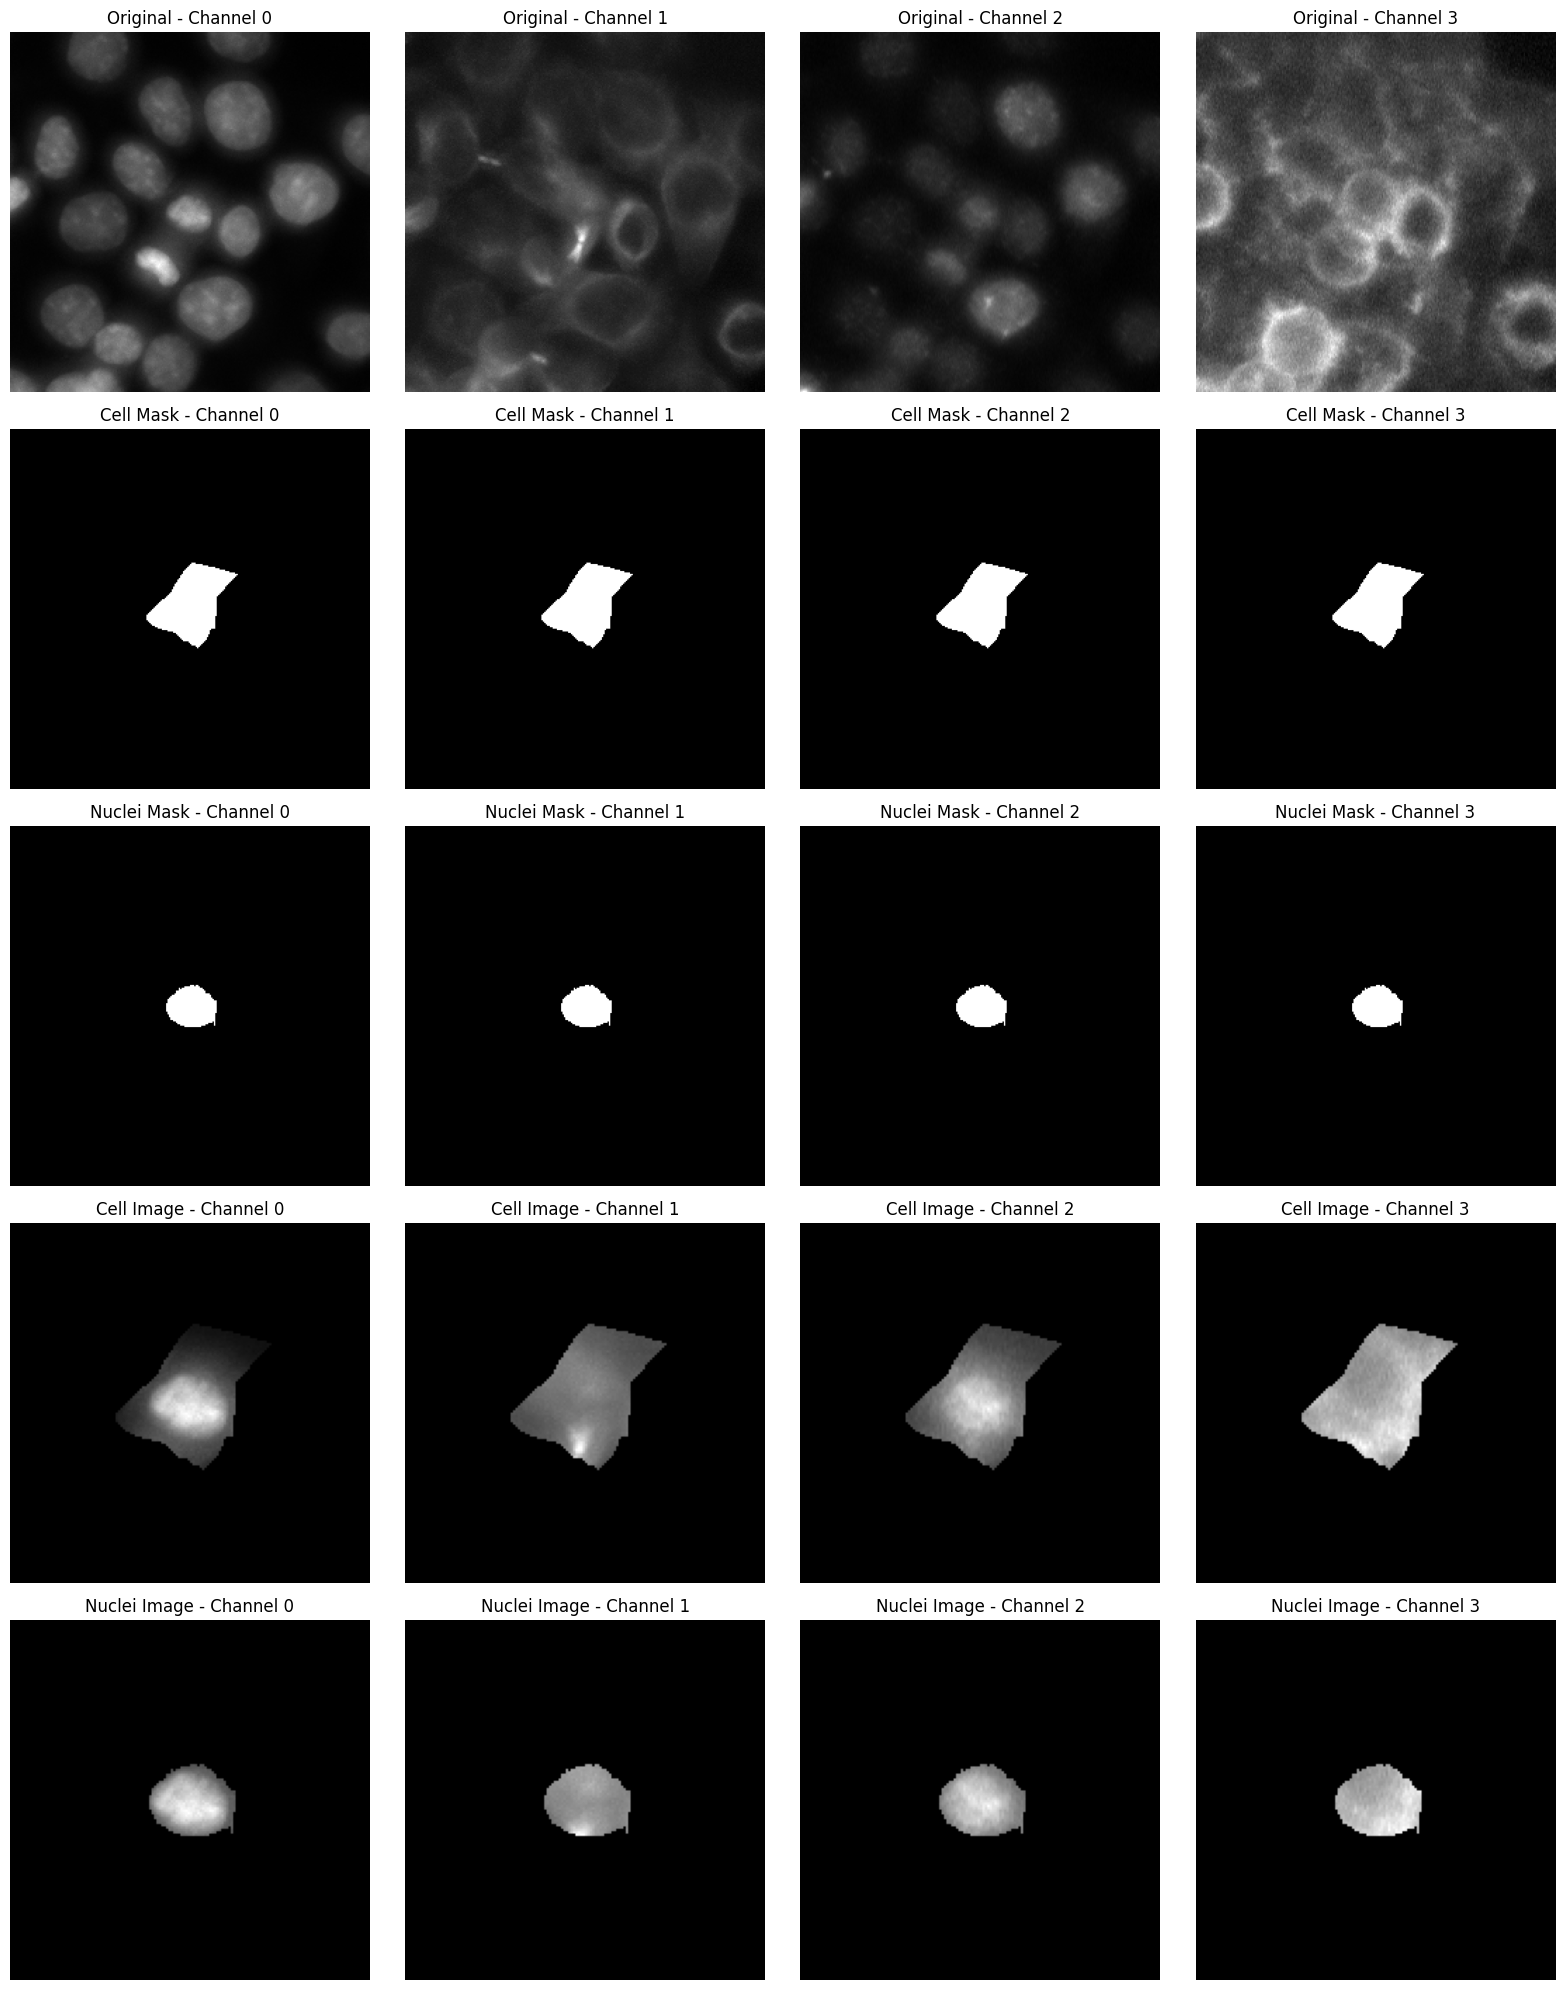

In [79]:
# Usage example:
parent_dir = '/mnt/efs/dlmbl/S-md/'
csv_file = '/home/S-md/embed_time/notebooks/splits/example_split.csv'
split = 'train'
channels = [0, 1, 2, 3]
cell_cycle_stages = 'interphase'
transform = "masks"
crop_size = 150

# Create the dataset
dataset = ZarrCellDataset(parent_dir, csv_file, split, channels, transform, crop_size)

# Print the number of images and shapes of the data
print(f"The dataset contains {len(dataset)} images.")

# Print the shapes of the data for the first image
print_cell_data_shapes(dataset.__getitem__(42))

# Plot the first image (index 0)
plot_cell_data(dataset.__getitem__(42))

In [80]:
# Define the metadata keys
metadata_keys = ['gene', 'barcode', 'stage']
images_keys = ['original_image', 'cell_image']

# Create a DataLoader for the dataset
dataloader = DataLoader(
    dataset, 
    batch_size=2, 
    shuffle=True, 
    collate_fn=collate_wrapper(metadata_keys, images_keys)
)

In [81]:
# Iterate over the DataLoader
for i, batch in enumerate(dataloader):
    print(f"Batch {i}:")
    print(f"Gene:" , batch['gene'])
    print(f"Barcode:" , batch['barcode'])
    print(f"Stage:" , batch['stage'])
    print(f"Original Image: {batch['original_image'].shape}")
    print(f"Cell Image: {batch['cell_image'].shape}")
    break

# If you want to move the batch to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch = batch.to(device)

Batch 0:
Gene: ('AAAS', 'AAGAB')
Barcode: ('CCACACCAACAAGTTTGCAG', 'GCCATGAGGAGACACTATCA')
Stage: ('interphase', 'interphase')
Original Image: torch.Size([2, 4, 256, 256])
Cell Image: torch.Size([2, 4, 150, 150])
